# PI-ICR Analysis Workflow

To run the analysis for a PI-ICR dataset, follow the steps outlined below in order

In [1]:
# Define the necessary imports for the analysis code
import numpy as np
import matplotlib
from copy import deepcopy
import os

from Modules.PIICR_Utilities import loadAllDataFiles, cart2pol, pol2cart, cart2Pol_withUnc, extract_configuration
from Modules.FitSpot import SpotFitter
from Modules.FitEllipse import EllipseFitter
from Modules.ClusterPIICR import ClusterPIICR
from Modules.AnalysisGUI_Utilities import launchFitGUI

from Modules.CircleDataset import CircleDataset
from Modules.MagDataset import MagDataset
from Modules.StartDataset import StartDataset
from Modules.TwoPhaseAccumDataset import TwoPhaseAccumDataset

# Extract the user settings from the ini file
CWD = os.path.abspath("") # for running from code
ini_path = os.path.join(CWD, 'VisualizationGUI.ini')
(tdcInfo, piSystem, loose_limits, piDataFile, piAnalysisFile, nbinsPosn, 
    cntrateHistory, user_fig_scale, user_font_scale) = extract_configuration(ini_path)

# Define some objects for running the analysis
piCluster = ClusterPIICR(piSystem.getRadiusMCP())
spotFitter = SpotFitter()
ellipseFitter = EllipseFitter()

# These limits will be used during the fitting to specify additional restrictions on the dataset. 
limits = deepcopy(loose_limits)

tofmin, tofmax = piSystem.getAbsTofLimits()
settings = {
    'tofwindowmin':tofmin, 'tofwindowmax':tofmax, # range of the visible tof sprectrum to plot
    'toffilter':True, # Whether or not to use the tof filter
    'zfilter':True, # Whether or not to use the count/shot filter
    'radialfilter':False, # Whether or not to use the radial filter
    'angularfilter':False, # Whether or not to use the angular filter
    'allowRecovered':True, # Whether to allow positions recovered from incomplete timing info
    'overrideFilterCenter':False, # Whether to allow user to choose center for spatial filters
    'hideRejectedPoints':False, # Whether to hide the points rejected by filters, etc.
    'filterCenterXY':[0,0], # The center for the filters, used only if overrideFilterCenter is True
    'clusterthresh':0.15, # cluster threshold, (min of 0.01, max of 0.99)
    'clustersmooth':1, # cluster smoothing, (min of 0.01, max of 5)
    'clustertype':'spot', # 'spot' or 'ellipse' to determine how to cluster the data
    'plotstyle':'image', # How to plot the position data, 'image', 'contour', or 'scatter'
    'fitfunctionkey':'Cartesian Spot' # key for the default fit method, defined in dictionary below!
}

## Load in the Data Files to Analyize

In [30]:
#---------------------------------------------------------------
# Provide a path to the directrory containing the data files
#---------------------------------------------------------------
posDataDir = piSystem.getMcpDataDirectory() # Use default specified in ini (e.g. I:\projects\lebit/DATA/currentPI-ICRData)
# posDataDir = r'I:\\projects\\lebit\\DATA\\dataBackupPI-ICR\\2023\\PI-ICR_Data\\230420_230728\\' # use files from a backup location
# posDataDir = r'I:\\projects\\lebit\\User\\Scott\\Papers_and_References\\Aluminum22\\230420_PI_Ne22vNa23\\'

#---------------------------------------------------------------
# If you wish to provide your own frequency guesses, do so here
#---------------------------------------------------------------
initial_Fm_guess = 1873 # None: uses the frequencies from the MM8 file
initial_Fp_guess = 2874055 # None: uses the frequencies from the MM8 file

#---------------------------------------------------------------
# Provide the file numbers for the corresponing file types
#---------------------------------------------------------------
centerFileNums = [733, 755] # = [] # Use [] if you don't have any center/circle datasets to analyze
startFileNums  = [734, 744, 756] # = [] # Use [] if you don't have any datasets to analyze
magFileNums    = [735, 745, 757] # = [] # Use [] if you don't have any datasets to analyze
accumFileNums  = [736, 746, 758] # = [] # Use [] if you don't have any datasets to analyze
# magFileNums    = [737, 747, 757] # = [] # Use [] if you don't have any datasets to analyze
# accumFileNums  = [738, 748, 760] # = [] # Use [] if you don't have any datasets to analyze

#---------------------------------------------------------------
# Load all the datafiles to be fit
#---------------------------------------------------------------
centerFiles = loadAllDataFiles(posDataDir, centerFileNums, piSystem, loose_limits)
startFiles  = loadAllDataFiles(posDataDir, startFileNums,  piSystem, loose_limits)
magFiles    = loadAllDataFiles(posDataDir, magFileNums,    piSystem, loose_limits)
accumFiles  = loadAllDataFiles(posDataDir, accumFileNums,  piSystem, loose_limits)

## Define functions for performing the fitting

These functions are used to fit the PI-ICR data. You can create new methods, though you must follow the style guideline so that the functions interface properly with the plotting GUI

The launchFitGUI method requires the fit function to have the following structure: 

> def func(data, (init param tuple), center, centerErr=[0,0]):  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;return (param name tuple), (fit param tuple), (fit param err tuple), plot_function_handle

The required arguments are:  
1. data is a 2D list of the points to fit (x in first col, y in second)
1. the paramter tuple allows you to pass as many parameters as needed to perform the fit (so long as they are contained inside of the tuple!). Some of the init params may be provided as 'None' type, and the fit method will need to be able to handle this
1. The center value is subtracted off the positions BEFORE fitting. This is the center of motion for the ions on the MCP.

The required returns are (all values are RELATIVE to the provided center):
1. a tuple of strings for each parameter name (same length as the init param tuple!)
1. a tuple of the fitted parameter values (same length as the init param tuple!)
1. a tuple of the fitted parameter errors (same length as the init param tuple!)
1. a function handle which plots the fit, who has only one argument (figure axes object), and returns the 2D artist object (e.g. ax.plot(...))

In [24]:
def cartSpotFit(data, init_param_tuple, center, centerErr=[0,0]):
    """ Note: as is, this method does not use inital guesses! 
        This method needs to be able to handle None values in
            init_param_tuple!
    """
    fit_dict = spotFitter.fit2DCartesianGaussian(np.array(data) - center, dataErr=centerErr)
    def plot_fit(ax):
        phi = np.linspace(0, 2*np.pi, 1000)
        theta_rad = fit_dict['rot_theta'] * np.pi/180
        x_list = fit_dict['sigma_x']*np.cos(phi)*np.cos(theta_rad) - fit_dict['sigma_y']*np.sin(phi)*np.sin(theta_rad) + fit_dict['mean_x'] + center[0]
        y_list = fit_dict['sigma_x']*np.cos(phi)*np.sin(theta_rad) + fit_dict['sigma_y']*np.sin(phi)*np.cos(theta_rad) + fit_dict['mean_y'] + center[1]
        pl1 = ax.plot(fit_dict['mean_x']+center[0], fit_dict['mean_y']+center[1], 'x', color='mediumseagreen', markersize=7, markeredgewidth=3, alpha=1, label='Center')
        pl2 = ax.plot(x_list, y_list, '-', color='yellowgreen', linewidth=2, alpha=1, label = r'1$\sigma$')
        ax.legend()
        return pl1, pl2
    
    return ('Mean x', 'Mean y', 'Sigma x', 'Sigma y', 'Rot Angle'), \
           (fit_dict['mean_x'], fit_dict['mean_y'], fit_dict['sigma_x'], fit_dict['sigma_y'], fit_dict['rot_theta']), \
           (fit_dict['mean_x_err'], fit_dict['mean_y_err'], fit_dict['sigma_x_err'], fit_dict['sigma_y_err'], fit_dict['rot_theta_err']), \
           plot_fit

def polarSpotFit(data, init_param_tuple, center, centerErr=[0,0]):
    """ Note: as is, this method does not use inital guesses! 
        This method needs to be able to handle None values in
            init_param_tuple!
        Args:
            data (2D list): positions in CARTESIAN coords!
    """
    rho, phi = cart2pol(data[:,0]-center[0], data[:,1]-center[1])
    # Determine radius and angle uncertainty based on center error
    rhoErr = np.sqrt( centerErr[0]**2 + centerErr[1]**2 )
    phiErr = 0

    RP_data = np.transpose(np.concatenate(([rho],[phi]), axis=0))
    fit_dict = spotFitter.fit2DPolarGaussian(RP_data, dataErr=[rhoErr, phiErr])
    def plot_fit(ax):
        mean_rho, mean_phi, sigma_rho, sigma_phi = fit_dict['mean_rho'], fit_dict['mean_phi'], fit_dict['sigma_rho'], fit_dict['sigma_phi']
        mean_x, mean_y = mean_rho*np.cos(mean_phi), mean_rho*np.sin(mean_phi)
        t_list = np.linspace(0,2*np.pi,500)
        phi_list, rho_list = mean_phi + sigma_phi*np.cos(t_list), mean_rho + sigma_rho*np.sin(t_list)
        x_list, y_list = pol2cart(rho_list, phi_list)
        pl1 = ax.plot(mean_x+center[0], mean_y+center[1], 'x', color='mediumseagreen', markersize=7, markeredgewidth=3, alpha=1, label='Center')
        pl2 = ax.plot(np.array(x_list)+center[0], np.array(y_list)+center[1], '-', color='yellowgreen', linewidth=2, alpha=1, label = r'1$\sigma$')
        ax.legend()
        return pl1, pl2
    
    return ('Mean rho', 'Mean phi', 'Sigma rho', 'Sigma phi'), \
           (fit_dict['mean_rho'], (180/np.pi)*fit_dict['mean_phi'], fit_dict['sigma_rho'], (180/np.pi)*fit_dict['sigma_phi']), \
           (fit_dict['mean_rho_err'], (180/np.pi)*fit_dict['mean_phi_err'], fit_dict['sigma_rho_err'], (180/np.pi)*fit_dict['sigma_phi_err']), \
           plot_fit

def ellipseFit(data, init_param_tuple, center, centerErr=[0,0]):
    """ Note: as is, this method does not use inital guesses! 
        This method needs to be able to handle None values in
            init_param_tuple!
    """
    datatemp = np.array(data) - center
    # Get the coefficeints of the conic form
    params = ellipseFitter.fit(datatemp[:,0], datatemp[:,1])
    # Calculate the errors of the fitted coefficents
    params = ellipseFitter.errors(datatemp[:,0], datatemp[:,1], params) # params are a ufloat object (uncertainties package). -> params[0].n gets the val, params[0].s gets the uncertainty
    # Convert the conic coeffs to the parametrized cartesian form
    ell_center, a, b, theta = ellipseFitter.convert(params) # params are a ufloat object (uncertainties package). -> params[0].n gets the val, params[0].s gets the uncertainty
    # Calculate the parameters for the upper and lower confidence intervals
    c_up, c_do = ellipseFitter.confidence_area(datatemp[:,0], datatemp[:,1], [i.n for i in params], f=1) # f tells how many sigma to go out
    center_up, a_up, b_up, theta_up = ellipseFitter.convert(c_up) 
    center_do, a_do, b_do, theta_do = ellipseFitter.convert(c_do) 

    def plot_fit(ax):
        phi = np.linspace(0, 2*np.pi, 1000)
        x = a.n*np.cos(phi)*np.cos(theta.n) - b.n*np.sin(phi)*np.sin(theta.n) + ell_center[0].n + center[0]
        y = a.n*np.cos(phi)*np.sin(theta.n) + b.n*np.sin(phi)*np.cos(theta.n) + ell_center[1].n + center[1]
        x_do = a_do*np.cos(phi)*np.cos(theta_do) - b_do*np.sin(phi)*np.sin(theta_do) + center_do[0] + center[0]
        y_do = a_do*np.cos(phi)*np.sin(theta_do) + b_do*np.sin(phi)*np.cos(theta_do) + center_do[1] + center[1]
        x_up = a_up*np.cos(phi)*np.cos(theta_up) - b_up*np.sin(phi)*np.sin(theta_up) + center_up[0] + center[0]
        y_up = a_up*np.cos(phi)*np.sin(theta_up) + b_up*np.sin(phi)*np.cos(theta_up) + center_up[1] + center[1]
        pl1, = ax.plot(x, y, '-', color='mediumseagreen', linewidth=2, alpha=1, label='Fit')
        pl2, = ax.plot(x_do, y_do, '-', color='yellowgreen', linewidth=2, alpha=1, label=r'1$\sigma$')
        pl3, = ax.plot(x_up, y_up, '-', color='yellowgreen', linewidth=2, alpha=1)
        ax.legend()
        return pl1, pl2, pl3

    return ('Center x', 'Center y', 'Major (a)', 'Minor (b)', 'Rot Angle'), \
           (ell_center[0].n, ell_center[1].n, a.n, b.n, theta.n*180/np.pi), \
           (ell_center[0].s, ell_center[1].s, a.s, b.s, theta.s*180/np.pi), \
           plot_fit
    
fitmethods = {
    "Ellipse": ellipseFit,
    "Polar Spot": polarSpotFit,
    "Cartesian Spot": cartSpotFit
}

def determineFileCenters(centerDataset, analysisfile_list):
    """ 
    Args:
        centerDataset (CenterDataset obj): dataset to interpolate the ion center of motion for
        analysisfile_list (list of AnalysisFile obj): all files to update their 'center' value (center of ion motion in trap)
    Returns: none (files are passed by reference and updated dynamically)
    """
    for file in analysisfile_list:
        interpCenter, interpCenterErr = centerDataset.interpCenter(file.getMidTime())
        file.setCenter(interpCenter)
        file.setCenterErr(interpCenterErr)
        # If the center dataset was made using ellipse fits, we will save those for the spots here as well
        # NOTE: this code will use 'None' if an ellipse fit wasn't used.
        interpParams = centerDataset.interpEllipseParams(file.getMidTime())
        file.setEllipseParams(interpParams)

def extractSpotLocationFromFit(analysisfile_list, fitparam_dicts, fitparamerr_dicts, data_type='spot'):
    """ Takes one of the fits from the above functions and extracts the 
        spot location in polar coordinates 
    Args:
        analysisfile_list (list of AnalysisFile obj): all files which have been fit
        fitparam_dicts (list of Dict): dictionaries containing all the fit parameter values
        firparamerr_dicts (list of Dict): dictionaries containing all the fit parameter errors
        data_type ('spot' or 'center'): determines how to interpret the fit
    Returns:
        list of AnalysisFile obj with the center/spot location saved
    """
    saved_analysisfiles = []
    #------------------------------------------------------------------------
    # If the datatype is for a center of motion measurement, we only use the
    #   ellipse fit or the cartesian spot fit!
    if data_type == 'center':
        for kk, currfile in enumerate(analysisfile_list):
            if fitparam_dicts[kk] == None: continue # skip this datafile if no fit was performed
            fitmethod = fitmethods[fitparam_dicts[kk]['fitmethod']]
            # If you used a cartesian spot fit
            if fitmethod == cartSpotFit:
                currfile.setCenter( [fitparam_dicts[kk]['param1'], fitparam_dicts[kk]['param2']] )
                currfile.setCenterErr( [fitparamerr_dicts[kk]['param1err'], fitparamerr_dicts[kk]['param2err']] )
            # Used an ellipse fit to determine the center
            elif fitmethod == ellipseFit: 
                currfile.setCenter( [fitparam_dicts[kk]['param1'], fitparam_dicts[kk]['param2']] )
                currfile.setCenterErr( [fitparamerr_dicts[kk]['param1err'], fitparamerr_dicts[kk]['param2err']] )
            else: print("WARNING: only a cartesian spot fit or a ellipse fit is valid for the center datasets! File "+str(analysisfile_list[kk].getFileName())+" will be ignored.")
            saved_analysisfiles.append(currfile)
    #------------------------------------------------------------------------
    # If the datatype is for a center of motion measurement, we only use the
    #   ellipse fit or the cartesian spot fit!
    else:
        for kk, currfile in enumerate(analysisfile_list):
            if fitparam_dicts[kk] == None: continue # skip this datafile if no fit was performed
            fitmethod = fitmethods[fitparam_dicts[kk]['fitmethod']]
            # If you used a cartesian spot fit
            if fitmethod == cartSpotFit:
                xy = [fitparam_dicts[kk]['param1'], fitparam_dicts[kk]['param2']]
                xyErr = [fitparamerr_dicts[kk]['param1err'], fitparamerr_dicts[kk]['param2err']]
                center, centerErr = currfile.getCenter(), currfile.getCenterErr()
                rho, rhoErr, phi, phiErr = cart2Pol_withUnc(xy, xyErr, center=center, centerErr=centerErr)
            # If you used a polar fit
            elif fitmethod == polarSpotFit:
                rho, phi = fitparam_dicts[kk]['param1'], fitparam_dicts[kk]['param2']
                rhoErr, phiErr = fitparamerr_dicts[kk]['param1err'], fitparamerr_dicts[kk]['param2err']
            else: print("WARNING: only a cartesian spot fit or a polar spot fit is valid for the excited spot datasets! File "+str(analysisfile_list[kk].getFileName())+" will be ignored.")
        
            currfile.setSpotRho(rho)
            currfile.setSpotRhoErr(rhoErr)
            currfile.setSpotPhi(phi) # should always be in degrees!
            currfile.setSpotPhiErr(phiErr) # should always be in degrees!
            saved_analysisfiles.append(currfile)

    return saved_analysisfiles

## Determine location for the ions' center of motion

Fitting and analyzing the data may require knowing where the center of the elliptical/circular motion is (specifically if fitting in polar coordinates). If this is to be done, you need to run this code to fit an ellipse or center spot from the dataset. By default, the code will use (0,0) as the center if you do not provide any datafiles.

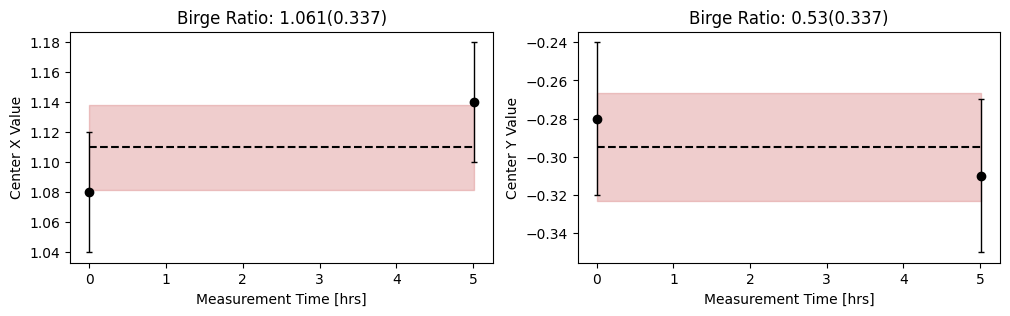

--------------------------------------------------
Aggregate Dataset Fit:
--------------------------------------------------
	Weighted Center X: 1.11 0.028
	Weighted Center y: -0.295 0.028



In [25]:
%matplotlib inline
#--------------------------------------------------------
# Load the files, and perform the fits
centerParamDicts, centerParamErrDicts = launchFitGUI(centerFiles, piSystem, limits, settings, piCluster, fitmethods, nbinsPosn)
#--------------------------------------------------------
# Update the datafiles to reflect the fits
savedCenterFiles = extractSpotLocationFromFit(centerFiles, centerParamDicts, centerParamErrDicts, data_type='center')
#--------------------------------------------------------
# Create the dataset with the saved files
circleDataset = CircleDataset(savedCenterFiles, interp_method="constant") # interp_method = 'linear', 'constant', or 'nearest'

## Determine locations of all start spots

Specify the files to investigate/fit below. These should only contain datafiles which represent the 'start spot', which has no magnetron or reduced cyclotron accumulation time (relative to the 'final spots')

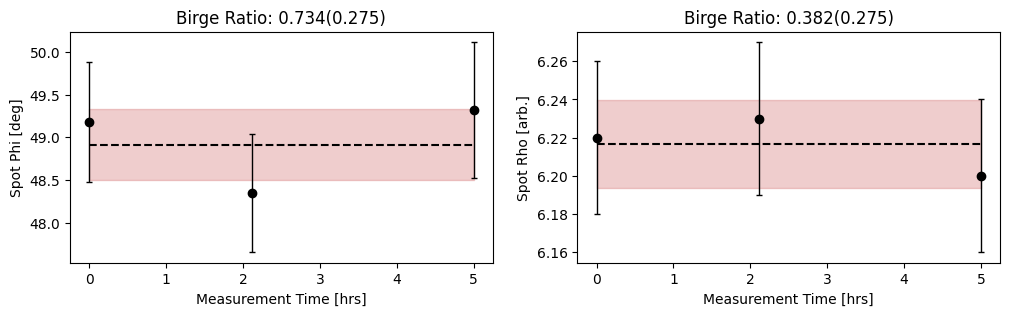

--------------------------------------------------
Aggregate Dataset Fit:
--------------------------------------------------
	Weighted Spot Phi: 48.916 0.417
	Weighted Spot Rho: 6.217 0.023

--------------------------------------------------
File: 241202_734_ti50.raw     Species: 1Ti50
--------------------------------------------------
	             Counts: 343
	       Ang Location: 49.18 ± 0.7
--------------------------------------------------
File: 241202_744_ti50.raw     Species: 1Ti50
--------------------------------------------------
	             Counts: 341
	       Ang Location: 48.35 ± 0.69
--------------------------------------------------
File: 241202_756_ti50.raw     Species: 1Ti50
--------------------------------------------------
	             Counts: 293
	       Ang Location: 49.32 ± 0.79


In [26]:
%matplotlib inline
#--------------------------------------------------------
# Determine the center of motion for each spot datafile
determineFileCenters(circleDataset, startFiles)
#--------------------------------------------------------
# Load the files, and perform the fits NOTE: all fit params are RELATIVE to the ions center of motion! Important when using cartesian fit!
startParamDicts, startParamErrDicts = launchFitGUI(startFiles, piSystem, limits, settings, piCluster, fitmethods, nbinsPosn)
#--------------------------------------------------------
# Update the datafiles to reflect the fits
savedStartFiles = extractSpotLocationFromFit(startFiles, startParamDicts, startParamErrDicts, data_type='spot')
#--------------------------------------------------------
# Create the dataset with the saved files
startDataset = StartDataset(savedStartFiles, interp_method="constant") # interp_method = 'linear', 'constant', or 'nearest'

## Determine locations of all the magnetron spots

Specify the files to investigate/fit below. These should only contain datafiles which represent the 'magnetron spot', which has a net magnetron accumulation/wait time (relative to the 'start spot') and is used to determine the magnetron frequency.

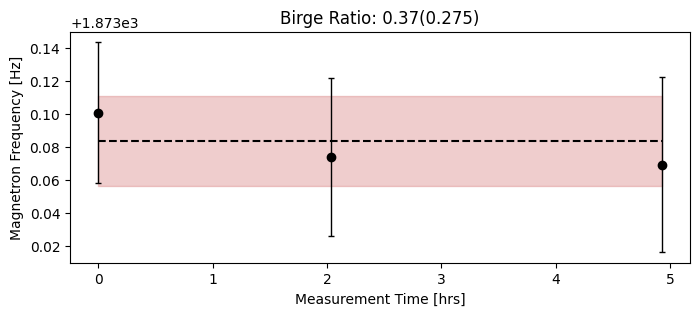

--------------------------------------------------
Aggregate Dataset Fit:
--------------------------------------------------
	Weighted Mag Freq: 1873.083 0.027

--------------------------------------------------------------------------------
File: 241202_735_ti50.raw     Species: 1Ti50
--------------------------------------------------------------------------------
	                  Counts: 369
	  Net F- Accum Time [μs]: 52860.0
	      Ang Location [deg]: 53.27 ± 0.7
	       F- Frequency [Hz]: 1873.101 ± 0.043, (n±1: 18.918 Hz)
--------------------------------------------------------------------------------
File: 241202_745_ti50.raw     Species: 1Ti50
--------------------------------------------------------------------------------
	                  Counts: 296
	  Net F- Accum Time [μs]: 52860.0
	      Ang Location [deg]: 52.76 ± 0.81
	       F- Frequency [Hz]: 1873.074 ± 0.048, (n±1: 18.918 Hz)
--------------------------------------------------------------------------------
File: 241

In [31]:
%matplotlib inline
#--------------------------------------------------------
# Determine the center of motion for each spot datafile
determineFileCenters(circleDataset, magFiles)
#--------------------------------------------------------
# Load the files, and perform the fits NOTE: all fit params are RELATIVE to the ions center of motion! Important when using cartesian fit!
magParamDicts, magParamErrDicts = launchFitGUI(magFiles, piSystem, limits, settings, piCluster, fitmethods, nbinsPosn)
#--------------------------------------------------------
# Update the datafiles to reflect the fits
savedMagFiles = extractSpotLocationFromFit(magFiles, magParamDicts, magParamErrDicts, data_type='spot')
#--------------------------------------------------------
# Create the dataset with the saved files
magDataset = MagDataset(savedMagFiles, startDataset, interp_method="constant", 
                        initial_Fm_guess=initial_Fm_guess, initial_Fp_guess=initial_Fp_guess) # interp_method = 'linear', 'constant', or 'nearest'

## Determine locations of all the final spots

Specify the files to investigate/fit below. These should only contain datafiles which represent the 'final spot', which has a net reduced cyclotron phase accumulation time (relative to the 'start spot') and is used to determine the reduced cyclotron frequency.

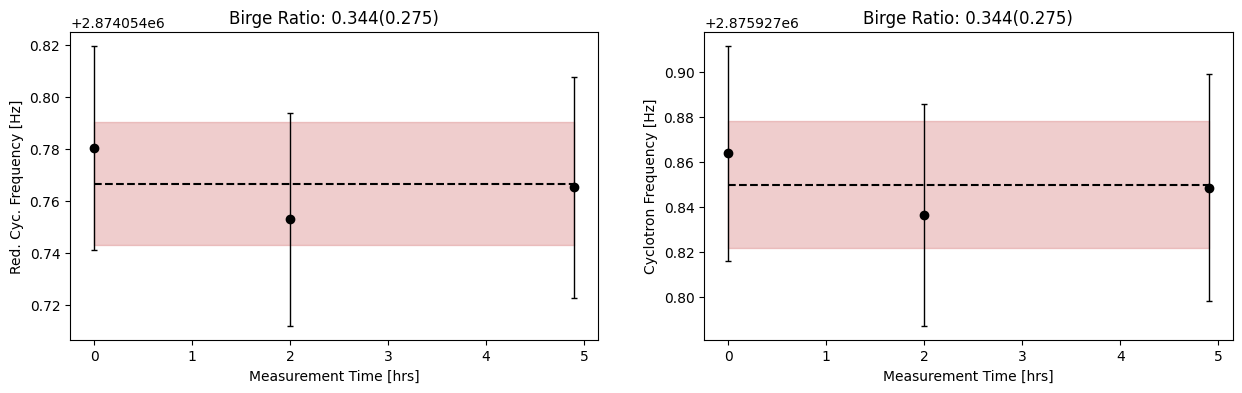

--------------------------------------------------------------------------------
File: 241202_736_ti50.raw     Species: 1Ti50
--------------------------------------------------------------------------------
	                  Counts: 297
	  Net F+ Accum Time [μs]: 72999.0
	      Ang Location [deg]: 37.66 ± 0.94
	       F+ Frequency [Hz]: 2874054.78 ± 0.039, (n±1: 13.699 Hz)
	       Fc Frequency [Hz]: 2875927.864 ± 0.048
--------------------------------------------------------------------------------
File: 241202_746_ti50.raw     Species: 1Ti50
--------------------------------------------------------------------------------
	                  Counts: 299
	  Net F+ Accum Time [μs]: 72999.0
	      Ang Location [deg]: 38.38 ± 0.99
	       F+ Frequency [Hz]: 2874054.753 ± 0.041, (n±1: 13.699 Hz)
	       Fc Frequency [Hz]: 2875927.837 ± 0.049
--------------------------------------------------------------------------------
File: 241202_758_ti50.raw     Species: 1Ti50
-------------------------

In [32]:
%matplotlib inline
#--------------------------------------------------------
# Determine the center of motion for each spot datafile
determineFileCenters(circleDataset, accumFiles)
#--------------------------------------------------------
# Load the files, and perform the fits NOTE: all fit params are RELATIVE to the ions center of motion! Important when using cartesian fit!
accumParamDicts, accumParamErrDicts = launchFitGUI(accumFiles, piSystem, limits, settings, piCluster, fitmethods, nbinsPosn)
#--------------------------------------------------------
# Update the datafiles to reflect the fits
savedAccumFiles = extractSpotLocationFromFit(accumFiles, accumParamDicts, accumParamErrDicts, data_type='spot')
#--------------------------------------------------------
# Create the dataset with the saved files
accumDataset = TwoPhaseAccumDataset(savedAccumFiles, startDataset, magDataset,
                                    initial_Fm_guess=initial_Fm_guess, initial_Fp_guess=initial_Fp_guess)

## Save the Results to FT2 files for SOMA

In [33]:
saveFilePath = posDataDir
accumDataset.exportToFT2(saveFilePath)

Wrote FT2 file to I:\projects\lebit\DATA\currentPIMM8data\241202_736_ti50.ft2
Wrote FT2 file to I:\projects\lebit\DATA\currentPIMM8data\241202_746_ti50.ft2
Wrote FT2 file to I:\projects\lebit\DATA\currentPIMM8data\241202_758_ti50.ft2
